# IAPR Special Project - Find and solve the math problem in a video.

## Import packages

In [1]:
import itertools
import math
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np

from skimage.morphology import remove_small_objects, binary_closing
from skimage.filters import threshold_yen, unsharp_mask
from skimage.exposure import rescale_intensity
from tensorflow.keras.models import load_model
from tqdm.auto import tqdm

## Helper functions

In [2]:
def compute_angle(a, b, c):
    """Compute angle of point b given point a and c.

    Args:
        a, b, c: Three points.
    Return:
        float: Angles of abc.
    """
    ang = math.degrees(math.atan2(c[1] - b[1], c[0] - b[0]) - math.atan2(a[1] - b[1], a[0] - b[0]))
    return ang + 360 if ang < 0 else ang

In [3]:
def parse_equation(equations):
    """Parse the classification results.

    Args:
        equations: List of classification results (class indices).
    Return:
        string: Math equation.
    """
    str_eq = ''
    eq_map = { 0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8',
               9: '+', 10: '-', 11: '*', 12: '/', 13: '=' }
    for e in equations:
        str_eq += eq_map[e]

    if len(equations) > 1:
        if equations[-1] == 13:
            ans = eval(str_eq[:-1])
            str_eq += str(ans)

    return str_eq

In [4]:
def put_information(image, frame_string, eq_string):
    """Put information on the frame.

    Args:
        image: The image to put information on.
        frame_string: A string of frame number.
        eq_string: A string of the current equation.
    """
    frame_text_size, _ = cv2.getTextSize(frame_string, cv2.FONT_HERSHEY_DUPLEX, 1, 1)
    eq_text_size, _ = cv2.getTextSize(eq_string, cv2.FONT_HERSHEY_DUPLEX, 1, 1)
    # draw black backgrounds
    cv2.rectangle(image, (0, 480 - frame_text_size[1] - eq_text_size[1] - 30), (frame_text_size[0], 480), (0, 0, 0), -1)
    cv2.rectangle(image, (0, 480 - eq_text_size[1] - 20), (eq_text_size[0], 480), (0, 0, 0), -1)
    # write information
    cv2.putText(image, frame_string, (0, 480 - frame_text_size[1] - 25), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(image, eq_string, (0, 480 - 10), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)

In [5]:
def imshow(image, cmap='viridis'):
    """Plot the image.

    Args:
        image: The image that will be plotted.
        cmap: Color map.
    """
    plt.figure(figsize=(9, 6))
    plt.imshow(image, cmap=cmap)
    plt.show()

In [6]:
def mask_image(image, lower1, upper1, lower2, upper2):
    """Mask the image given color ranges.

    Args:
        image: The image that will be masked.
        lower1: 1st Lower color range.
        upper1: 1st Upper color range.
        lower2: 2nd Lower color range.
        upper2: 2nd Upper color range.
    Return:
        numpy.ndarray: The masked image.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask1 = cv2.inRange(hsv, lower1, upper1)
    mask2 = cv2.inRange(hsv, lower2, upper2)
    mask = mask1 + mask2
    res = cv2.bitwise_and(image, image, mask=mask)

    return res

In [7]:
def preprocess(image, min_size, threshold=True):
    """Preprocess the image.

    Args:
        image: The input image.
        min_size: Minimum size to be kept.
        threshold: Whether to apply thresholding.
    Return:
        numpy.ndarray: The preprocessed image.
    """
    # convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # apply thresholding
    if threshold:
        _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # remove small noises using morphology
    image = remove_small_objects(image.astype(bool), min_size=min_size)
    # fill holes using morphology
    image = binary_closing(image).astype(np.uint8)

    return image

In [8]:
def normalize(image):
    """Normalize the image to handle illumination differences.

    Args:
        image (numpy.ndarray): The input image.
    Return:
        numpy.ndarray: A normalized image in terms of intensity.
    """
    # convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # sharpen image
    image = unsharp_mask(image, radius=5, amount=4, preserve_range=True)
    # get the threshold using Yen's method
    yen_threshold = threshold_yen(image)
    # rescale the intensity with the threshold
    image = rescale_intensity(image, (0, yen_threshold), (0, 255))

    return image

## Load input video

Load input video


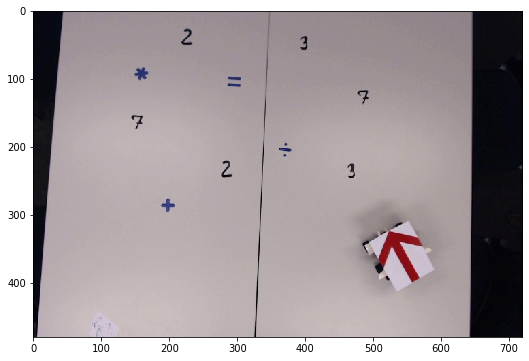

In [9]:
# load input video frames
print('Load input video')
cap = cv2.VideoCapture('../data/robot_parcours_1.avi')
frames = []
while cap.isOpened():
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)

cap.release()

angle = 0
M = cv2.getRotationMatrix2D((360, 240), angle, 1.0)
for i in range(len(frames)):
    frames[i] = cv2.warpAffine(frames[i], M, (720, 480))

imshow(frames[0])

## Detection functions

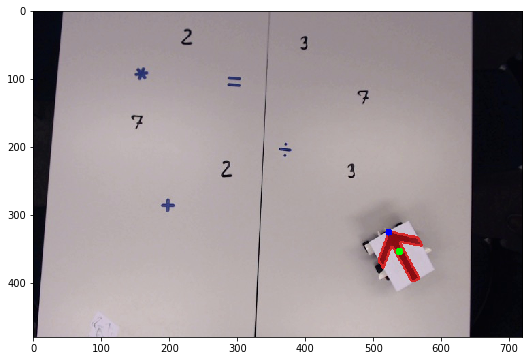

In [10]:
def find_red_arrow(image, show=False):
    """Detect the red arrow in the image.

    Args:
        image: The input image.
        show: Whether to show the results.
    Return:
        tuple: Tip coordinates.
        tuple: Center coordinates.
    """
    image_copy = image.copy()

    masked = mask_image(image_copy, np.array([0, 100, 0]), np.array([20, 255, 255]), np.array([160, 100, 0]), np.array([180, 255, 255]))
    preprocessed = preprocess(masked, 100, True)

    contours, _ = cv2.findContours(preprocessed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        # compute the centroid of the shapes
        M = cv2.moments(c)

        area = M['m00']
        # these will not be the arrow (too small or too big)
        if area < 1000 or area > 10000: continue

        cX = int(M['m10'] / area)
        cY = int(M['m01'] / area)
        center = (cX, cY)

        # Not sure do we need this
        # if abs(M['mu20'] - M['mu02']) > 420000: continue

        # find the corners of the arrow
        points = cv2.approxPolyDP(c, 4.7, True).squeeze(1)

        tip_idx = 0
        cand_tips = []
        angles = []

        # find tip candidates
        for i in range(len(points)):
            # get the current point and the surrounding points
            x = points[i - 1] if i != 0 else points[-1]
            y = points[i]
            z = points[i + 1] if i != len(points) - 1 else points[0]
            # get the lengths between the current point and the surrounding points
            l1 = np.linalg.norm(np.array(x) - np.array(y))
            l2 = np.linalg.norm(np.array(y) - np.array(z))

            ang = compute_angle(x, y, z)
            angles.append(ang)
            # save candidates
            if abs(ang - 100) < 15 and (l1 + l2 > 30):
                cand_tips.append(len(angles) - 1)

        # choose the correct tip
        for i in cand_tips:
            pang = angles[i - 1] if i != 0 else angles[-1]
            nang = angles[i + 1] if i != len(angles) - 1 else angles[0]
            if pang + nang < 300 and pang + nang > 200:
                tip_idx = i

        # visualize the result on the image
        cv2.drawContours(image_copy, [c], 0, (214, 39, 40), 2)
        cv2.circle(image_copy, tuple(center), 5, (0, 255, 0), -1)
        cv2.circle(image_copy, tuple(points[tip_idx]), 5, (0, 0, 255), -1)

        break

    if show:
        imshow(image_copy)

    return points[tip_idx], center

M = cv2.getRotationMatrix2D((360, 240), 0, 1.0)
tmp = cv2.warpAffine(frames[0], M, (720, 480)) 
tip, center = find_red_arrow(tmp, True)

In [11]:
int(cv2.cvtColor(frames[1], cv2.COLOR_RGB2HSV)[:, :, 2].mean())

151

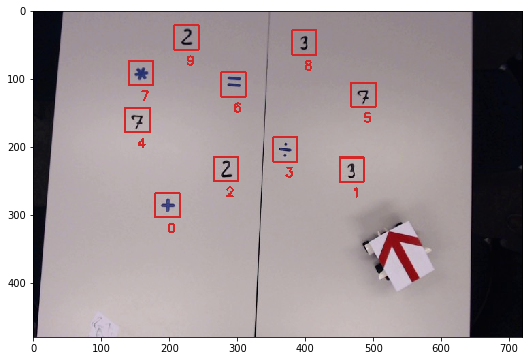

In [12]:
def find_math_elements(image, arrow_c, bound=20, show=False):
    """Detect math elements in the image.

    Args:
        image: The input image.
        arrow: Center of the arrow.
        bound: Bounding box size.
        show: Whether to show the results.
    Return:
        list: Images of all math elements.
        list: Center coordinates of math elements.
    """
    def elongation(m):
        x = m['mu20'] + m['mu02']
        y = 4 * m['mu11']**2 + (m['mu20'] - m['mu02'])**2
        return (x + y**0.5) / (x - y**0.5)
    image_original = image.copy()
    image_copy = image.copy()

    # cover red arrow with white rectangle
    cv2.rectangle(image_copy, (arrow_c[0] - 60, arrow_c[1] - 60), (arrow_c[0] + 60, arrow_c[1] + 60), (255, 255, 255), -1)

    value_threshold = int(cv2.cvtColor(image, cv2.COLOR_RGB2HSV)[:, :, 2].mean() * 0.9)
    masked = mask_image(image_copy,
                        np.array([0, 0, 0]), np.array([180, 255, value_threshold]),
                        np.array([100, 100, 0]), np.array([140, 255, 255]))
    preprocessed = preprocess(masked, 10, False)

    # get the contours of all shapes
    contours, _ = cv2.findContours(preprocessed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    centers = []
    elements = []

    for i, c in enumerate(contours):
        # compute the centroid of the shapes
        M = cv2.moments(c)

        area = M['m00']
        elongation_ = elongation(M)
        # these are either too small or too big
        if area < 40 or area > 400 or elongation_ > 3000: continue

        cY = int(M['m01'] / M['m00'])
        cX = int(M['m10'] / M['m00'])
        center = (cX, cY)

        # if it is too close to a known element, it is not a valid element
        too_close = False
        for center_ in centers:
            d = (center_[0] - center[0]) ** 2 + (center_[1] - center[1]) ** 2
            if d < 4000:
                too_close = True
                break
        if too_close: continue

        # save element and center
        element = image[cY - bound: cY + bound, cX - bound:cX + bound]
        element = cv2.resize(element, (28, 28))
        elements.append(element)
        centers.append(center)

        # visualize the result on the image
        label_color = (214, 39, 40)
        cv2.rectangle(image_original, (cX - bound, cY - bound), (cX + bound, cY + bound), label_color, 2)
        cv2.putText(image_original, f'{len(elements) - 1}', (cX, cY + 40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, label_color, 2)

    if show:
        imshow(image_original)

    return elements, centers

M = cv2.getRotationMatrix2D((360, 240), 0, 1.0)
tmp = cv2.warpAffine(frames[0], M, (720, 480)) 
tip, center = find_red_arrow(tmp)
elements, _ = find_math_elements(tmp, center, 18, True)

## Classification function

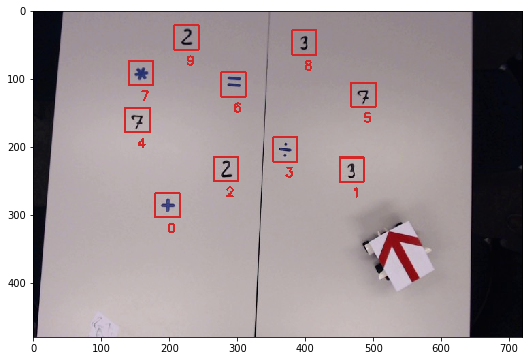

0: This is a +.
1: This is a 3.
2: This is a 2.
3: This is a /.
4: This is a 7.
5: This is a 7.
6: This is a =.
7: This is a *.
8: This is a 3.
9: This is a 2.


In [13]:
def classify(image, model):
    """Classify the math digits or operators.

    Args:
        image: The input image.
        model: The trained model.
    Return:
        numpy.ndarray: The predicted probability.
        int: The predicted class.
    """
    image = 255. - normalize(image)
    image = image[np.newaxis, :, :, np.newaxis] / 255.
    prob = model.predict(image)
    pred = np.argmax(prob)

    return prob, pred

# load model
model = load_model('iapr_project/models/model.h5')

M = cv2.getRotationMatrix2D((360, 240), 0, 1.0)
tmp = cv2.warpAffine(frames[0], M, (720, 480)) 
tip, center = find_red_arrow(tmp)
elements, _ = find_math_elements(tmp, center, 18, True)
for i in range(10):
    prob, pred = classify(elements[i], model)
    print(f'{i}: This is a {parse_equation([pred])}.')

## Main function

In [14]:
output_frames = []
arrow_centers = []
preds = []
equations = []

# process the first frame
frame_0 = frames[0].copy()

# find the arrow and math elements
last_tip, last_center = find_red_arrow(frame_0)
elements, centers = find_math_elements(frame_0, last_center, 18)
arrow_centers.append(last_center)
# draw the arrow center
cv2.circle(frame_0, tuple(last_center), 5, (255, 0, 0), -1)

# classify math elements and save predictions
for el in elements:
    prob, pred = classify(el, model)
    preds.append(pred)

# put text on the first frame (the robot will not be on any element in the first frame)
put_information(frame_0, 'Frame 1', 'Equation: ')

output_frames.append(frame_0)

tqdm_handle = tqdm(range(len(frames) - 1), total=len(frames), initial=1)
for i in tqdm_handle:
    # since the first frame was processed
    i += 1
    tqdm_handle.set_description(f'Frame {i + 1}')

    frame_c = frames[i].copy()

    tip, center = find_red_arrow(frame_c)
    arrow_centers.append(center)
    # plot arrow center and connect consecutive centers
    for c_idx, c in enumerate(arrow_centers):
        cv2.circle(frame_c, tuple(c), 5, (255, 0, 0), -1)
        if c_idx > 0:
            cv2.line(frame_c, tuple(arrow_centers[c_idx - 1]), tuple(c), (255, 0, 0), 1)

    # check whether the robot passes above an element
    intersect = None
    for c_i, c in enumerate(centers):
        if intersect != None: break
        for x in np.arange(0, center[0] - last_center[0], 1 if center[0] - last_center[0] > 0 else -1):
            if intersect != None: break
            for y in np.arange(0, center[1] - last_center[1], 1 if center[1] - last_center[1] > 0 else -1):
                p = [center[0] + x, center[1] + y]
                bound = 20
                if ((p[0] > (c[0] - bound)) and (p[0] < (c[0] + bound))) and ((p[1] > (c[1] - bound)) and (p[1] < (c[1] + bound))):
                    intersect = c_i
                    break

    last_tip = tip
    last_center = center

    # if the robot moves too slow, don't save the same element twice
    if intersect != None:
        if len(equations) == 0:
            equations.append(preds[intersect])
        elif equations[-1] != preds[intersect]:
            equations.append(preds[intersect])

    # put information on the frame
    str_eq = parse_equation(equations)
    put_information(frame_c, f'Frame {i + 1}', f'Equation: {str_eq}')

    output_frames.append(frame_c)

print(f'Equation: {str_eq}')


Equation: 3/2+7*2=15.5


In [15]:
# write video frames
print('Write output video')
out = cv2.VideoWriter(f'out_{angle}.avi', cv2.VideoWriter_fourcc('H','F','Y','U'), 2, (720, 480))
for f in output_frames:
    f = cv2.cvtColor(f, cv2.COLOR_RGB2BGR)
    out.write(f)

out.release()

Write output video


In [16]:
# # create more data
# ang = 350
# M = cv2.getRotationMatrix2D((360, 240), ang, 1.0)
# tmp = cv2.warpAffine(frames[0], M, (720, 480)) 
# tip, center = find_red_arrow(tmp)
# elements, _ = find_math_elements(tmp, center, 18)
# for idx, el in enumerate(elements):
#     im = normalize(el)
#     im = 255. - im
#     cv2.imwrite(f'data/{ang}_{idx}.png', im)